In [1908]:
import sys
import numpy as np

### 1. 确定决策变量和约束条件
决策变量 -> 表现型 X \
约束条件 -> 解空间 

### 2. 建立优化模型

In [1909]:
def f(x1, x2):
    part1 = np.power(x1, 2) - x2
    part2 = 1 - x1
    return 100 * np.power(part1, 2) + np.power(part2, 2)

### 3. 确定编码方法

In [1910]:
def to_bin(value, num):
    bin_chars = ''
    temp = value
    for i in range(num):
        bin_char = bin(temp % 2)[-1]
        temp = temp // 2
        bin_chars = bin_char + bin_chars
    return bin_chars.upper()

def encode():
    y1 = np.random.randint(0, 1024)
    y2 = np.random.randint(0, 1024)
    X1 = to_bin(y1, 10)
    X2 = to_bin(y2, 10)
    X = X1 + X2
    # return X1, X2
    return X

### 4. 确定解码方法

In [1911]:
# def decode(X1, X2):
def decode(X):
    X1 = X[:10]
    X2 = X[10:]
    y1 = int(X1, 2)
    y2 = int(X2, 2)
    x1 = 4.096 * y1 / 1023 - 2.048
    x2 = 4.096 * y2 / 1023 - 2.048
    return x1, x2


In [1912]:
# TEST encode decode
X = encode()
print(len(X[:10]), len(X[10:]))
decode(X)

10 10


(0.08208015640273691, 1.2992688172043008)

### 5. 确定个体评价方法 -> 计算适应度

In [1913]:
# def F(X):
def F(*args):
    # x1, x2 = decode(X)
    x1 = args[0]
    x2 = args[1]
    return f(x1, x2)

# F(0.2, 0.5)

### 6. 设计遗传算子

选择运算 -> 比例选择算子\
交叉运算 -> 单点交叉算子\
变异运算 -> 基本位变异算子\

### 7. 确定遗传算法的运行参数

In [1914]:
# 群体大小 
M = 80
# 中止迭代
Maxstep = 200
# 交叉概率
Pc = 0.6
# 变异概率
Pm = 0.001

### 8. 遗传算法主体部分

In [1915]:
def select_operator(fitness):
    """
    1. 计算出群体中所有个体的适应度的总和
    2. 计算每个个体的相对适应度的大小, 即每个个体被遗传到下一代的概率, 每个概率值组成一个区域, 全部区域的概率值之和为1
    3. 最后再产生一个0-1随机数, 依据该随机数出现在哪个区域确定各个个体被选中的次数
    """
    total_fit = np.sum(fitness[:,1], axis=0) 
    sele_prob = np.expand_dims(fitness[:,1]/total_fit, axis=1)
    cumu_prob = np.cumsum(sele_prob, axis=0)
    selected_indexcs = []
    for i in range(fitness.shape[0]):
        tmp = np.random.random()
        select_index = np.where(tmp < cumu_prob)[0][0]
        selected_indexcs.append(select_index)
    return selected_indexcs

# select_operator(np.array([[0, 24324], [1,34534], [2,45756], [3,54564]]))

In [1916]:
def crossover_operation(selected_group, gene_length=10):
    """
    1. 先对选择出来的群体进行随机配对
    2. 随机设置交叉点位置
    3. 相互交换配对的染色体之间的部分基因
    """
    crossover_group = []
    pairs_num = selected_group.shape[0]//2
    for i in range(pairs_num):
        Pairofgenes = selected_group[np.random.choice(selected_group.shape[0], 2, replace=False), :]
        crossover_position = np.random.randint(0, gene_length)
        gene_1 = Pairofgenes[0][1][:crossover_position+1] + Pairofgenes[1][1][crossover_position+1:]
        gene_2 = Pairofgenes[1][1][:crossover_position+1] + Pairofgenes[0][1][crossover_position+1:]
        crossover_group.append(gene_1)
        crossover_group.append(gene_2)
    return crossover_group

# crossover_operation(np.array([[0, "0000000000"], [1,"1111111111"], [2,"1010101010"], [3,"0101010101"]], dtype=object))

In [1917]:
def mutate_operation(crossover_operation, gene_length=10):
    """ 
    1. 确定各个个体的基因变异位置
    2. 依据某一概率将变异点的原有基因值取反
    """
    mutate_group = []
    for gene in crossover_operation:
        mutate_position = np.random.randint(0, gene_length)
        if np.random.random() < Pm:
            mutated_gene = gene[:mutate_position] + str(int(not(int(gene[mutate_position])))) + gene[mutate_position+1:]
            mutate_group.append(mutated_gene)
        else:
            mutate_group.append(gene)
    return mutate_group

# mutate_operation(["0000000000"])

In [1918]:
def create_newgroup(mutate_group):
    newgroup = np.asarray([[index, indiv] for index, indiv in enumerate(mutate_group)], dtype=object)
    return newgroup

In [1919]:
def main_genetic():
    # 初始化初代群体的基因
    group0 = np.asarray([[index, encode()] for index in range(M)], dtype=object)
    group  = group0
    # 设置迭代步数
    step = 0
    step_fit = []
    # 开始迭代
    while (step <= Maxstep):
        # 解码
        group_decode = np.asarray([[index, decode(X)] for index, X in group], dtype=object)
        
        # 计算, 评估适应度
        fitness = np.asarray([[index, F(*xi)] for index, xi in group_decode], dtype=object)
        max_fit = np.max(fitness[:, 1])

        # 选择运算: 依据与适应度成正比的概率将适应度较高的个体遗传到下一代群体中
        selected_indexes = select_operator(fitness)
        selected_group = np.asarray([[index, group[index, 1]] for index in selected_indexes], dtype=object)
        
        # 交叉运算
        crossover_group = crossover_operation(selected_group, 10)

        # 变异运算
        mutate_group = mutate_operation(crossover_group, 10)
        
        # 迭代出下一代群体
        group = create_newgroup(mutate_group)
        step += 1

        step_fit.append([step, max_fit])

    step_fit = np.asarray(step_fit)
    return step_fit

step_fit = main_genetic()

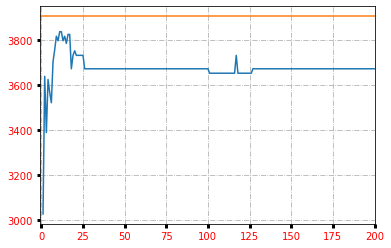

In [1920]:
import matplotlib.pyplot as plt
import numpy as np

x = step_fit[:, 0]
y = step_fit[:, 1]

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot([0,200], [3905.9296, 3905.9296])

ax.grid(True, linestyle='-.')
ax.tick_params(labelcolor='r', labelsize='medium', width=3)
ax.set_xlim(-1, 200)

plt.show()

#### 轮盘赌demo

In [1921]:
# 随机生成5个适应度值
X = np.random.randint(1, 10, 10)
index   = np.arange(len(X))
index_X = np.concatenate((index[:, np.newaxis], X[:, np.newaxis]), axis=1)

# 计算这五个适应度值的和
tot_X   = np.sum(X)

# 计算选择概率
sele_prob = np.expand_dims(X / tot_X, axis=1)

# 计算累计概率
cumu_prob = np.cumsum(sele_prob, axis=0)

index_X_prob = np.concatenate((index_X, sele_prob, cumu_prob), axis=1)
print(index_X_prob)

# 计算每个适应度值被选中的次数
selected_tot = []
for i in range(len(X)):
    tmp = np.random.random()
    selected_herit = np.where(tmp < index_X_prob[:, 3])[0][0]
    selected_tot.append(selected_herit)
selected_tot

[[0.         4.         0.0952381  0.0952381 ]
 [1.         3.         0.07142857 0.16666667]
 [2.         2.         0.04761905 0.21428571]
 [3.         4.         0.0952381  0.30952381]
 [4.         2.         0.04761905 0.35714286]
 [5.         7.         0.16666667 0.52380952]
 [6.         3.         0.07142857 0.5952381 ]
 [7.         6.         0.14285714 0.73809524]
 [8.         8.         0.19047619 0.92857143]
 [9.         3.         0.07142857 1.        ]]


[6, 7, 8, 3, 1, 8, 7, 6, 6, 8]